# News categorical multiclass classfication

## Rubric

### 1. 분류 모델의 accuracy가 기준 이상 높게 나왔는가?
    3가지 단어 개수에 대해 8가지 머신러닝 기법을 적용하여 그중 최적의 솔루션을 도출하였다.
### 2. 분류 모델의 F1 score가 기준 이상 높게 나왔는가?
    Vocabulary size에 따른 각 머신러닝 모델의 성능변화 추이를 살피고, 해당 머신러닝 알고리즘의 특성에 근거해 원인을 분석하였다.
### 3. 딥러닝 모델을 활용해 성능이 비교 및 확인되었는가?	
    동일한 데이터셋과 전처리 조건으로 딥러닝 모델의 성능과 비교하여 결과에 따른 원인을 분석하였다.

In [1]:
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

## All words

In [2]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

In [3]:
print('훈련 샘플의 수: {}'.format(len(x_train)))
print('테스트 샘플의 수: {}'.format(len(x_test)))

훈련 샘플의 수: 8982
테스트 샘플의 수: 2246


In [4]:
num_classes = max(y_train) + 1
print('클래스의 수 : {}'.format(num_classes))

클래스의 수 : 46


훈련용 뉴스의 최대 길이 :2376
훈련용 뉴스의 평균 길이 :145.5398574927633


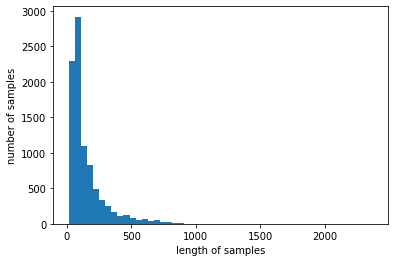

In [5]:
print('훈련용 뉴스의 최대 길이 :{}'.format(max(len(l) for l in x_train)))
print('훈련용 뉴스의 평균 길이 :{}'.format(sum(map(len, x_train))/len(x_train)))

plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [6]:
word_index = reuters.get_word_index(path="reuters_word_index.json")

In [7]:
index_to_word = {index + 3 : word for word, index in word_index.items()}

In [8]:
# index_to_word에 숫자 0은 <pad>, 숫자 1은 <sos>, 숫자 2는 <unk>를 넣어줍니다.
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

In [9]:
print(' '.join([index_to_word[index] for index in x_train[0]]))

<sos> mcgrath rentcorp said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3


In [10]:
def decode_data(data, index_to_word):
    decoded = []
    for item in data:
        t = ' '.join([index_to_word[index] for index in item])
        decoded.append(t)
    return decoded

In [11]:
x_train = decode_data(x_train, index_to_word)
x_test = decode_data(x_test, index_to_word)

In [12]:
# vectorize

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [14]:
#DTM

dtmvector = CountVectorizer()
x_train_dtm = dtmvector.fit_transform(x_train)
print(x_train_dtm.shape)

(8982, 26506)


In [15]:
#TF-IDF

tfidf_transformer = TfidfTransformer()
tfidfv = tfidf_transformer.fit_transform(x_train_dtm)
print(tfidfv.shape)

(8982, 26506)


In [16]:
x_test_dtm = dtmvector.transform(x_test) #테스트 데이터를 DTM으로 변환
tfidfv_test = tfidf_transformer.transform(x_test_dtm) #DTM을 TF-IDF 행렬로 변

In [17]:
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

In [18]:
def train_ml(tfidfv, y_train, tfidfv_test, y_test):
    models = [
        ('Naive Bayesian', MultinomialNB()),
        ('CNB', ComplementNB()),
        ('Logistic Regression', LogisticRegression(C=10000, penalty='l2', max_iter=1000)),
        ('Linear SVM', LinearSVC(C=1000, penalty='l1', max_iter=500, dual=False)),
        ('Decision tree', DecisionTreeClassifier(max_depth=10, random_state=0)),
        ('Random Forest', RandomForestClassifier(n_estimators=5, random_state=0)),
        ('Gradient Boosting tree', GradientBoostingClassifier(random_state=0, verbose=3)),
        ('Voting', VotingClassifier(estimators=[
            ('lr', LogisticRegression(C=10000, penalty='l2', max_iter=1000)),
            ('cb', ComplementNB()),
            ('grbt', GradientBoostingClassifier(random_state=0))
        ], voting='soft', n_jobs=-1))
    ]
    
    trained_models = []

    for name, model in models:
        print(f"Training and evaluating {name}...")
        model.fit(tfidfv, y_train)
        predictions = model.predict(tfidfv_test)
        accuracy = accuracy_score(y_test, predictions)
        f1 = f1_score(y_test, predictions, average='weighted')
        print(f"{name} 정확도:", accuracy)
        print(f"{name} F1 Score:", f1)
        graph_confusion_matrix(model, tfidfv_test, y_test)
        plt.title(f"Confusion Matrix for {name}")
        plt.show()
        trained_models.append(model)
    
    return trained_models

def graph_confusion_matrix(model, x_test, y_test):#, classes_name):
    df_cm = pd.DataFrame(confusion_matrix(y_test, model.predict(x_test)))#, index=classes_name, columns=classes_name)
    fig = plt.figure(figsize=(12,12))
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=12)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=12)
    plt.ylabel('label')
    plt.xlabel('predicted value')

Training and evaluating Naive Bayesian...
Naive Bayesian 정확도: 0.5997328584149599
Naive Bayesian F1 Score: 0.5045670886188423


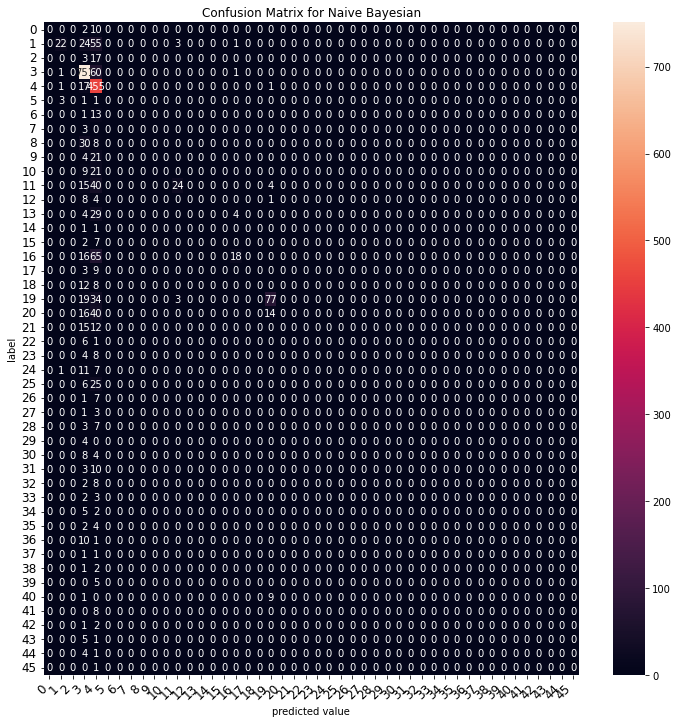

Training and evaluating CNB...
CNB 정확도: 0.7649154051647373
CNB F1 Score: 0.7346534179503126


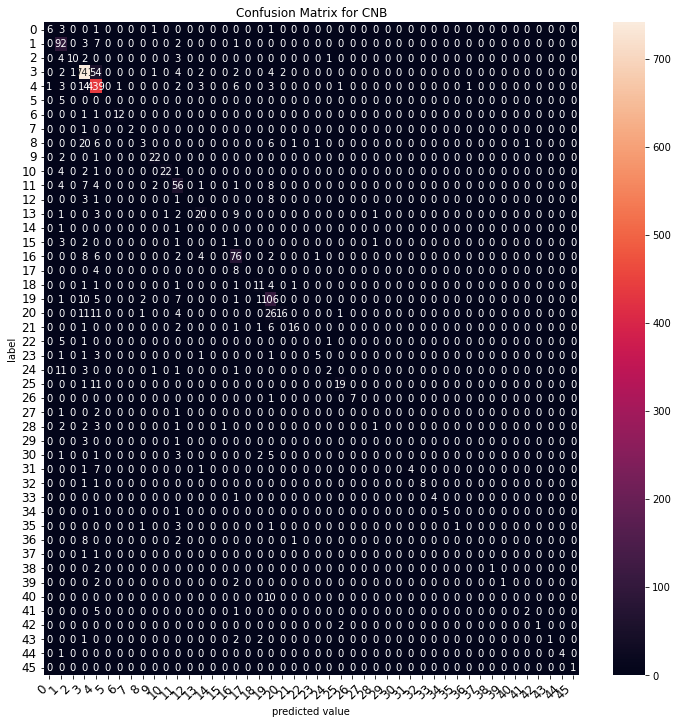

Training and evaluating Logistic Regression...


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression 정확도: 0.8161175422974176
Logistic Regression F1 Score: 0.811141369149163


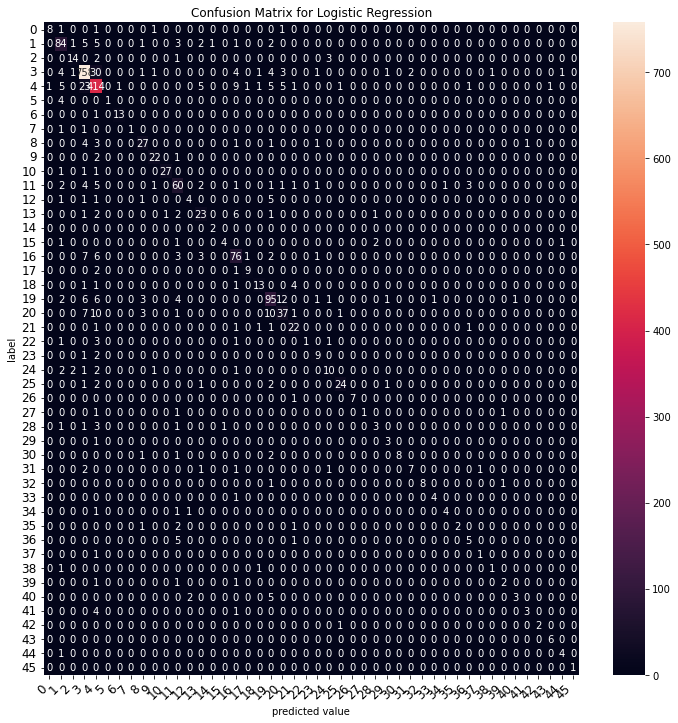

Training and evaluating Linear SVM...


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Linear SVM 정확도: 0.7778272484416741
Linear SVM F1 Score: 0.7727356735868885


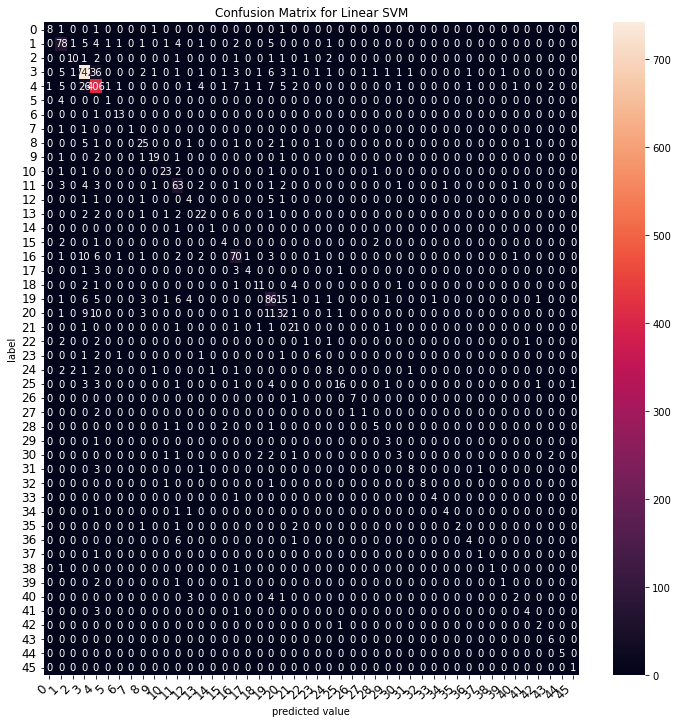

Training and evaluating Decision tree...
Decision tree 정확도: 0.6211041852181657
Decision tree F1 Score: 0.5769283128518846


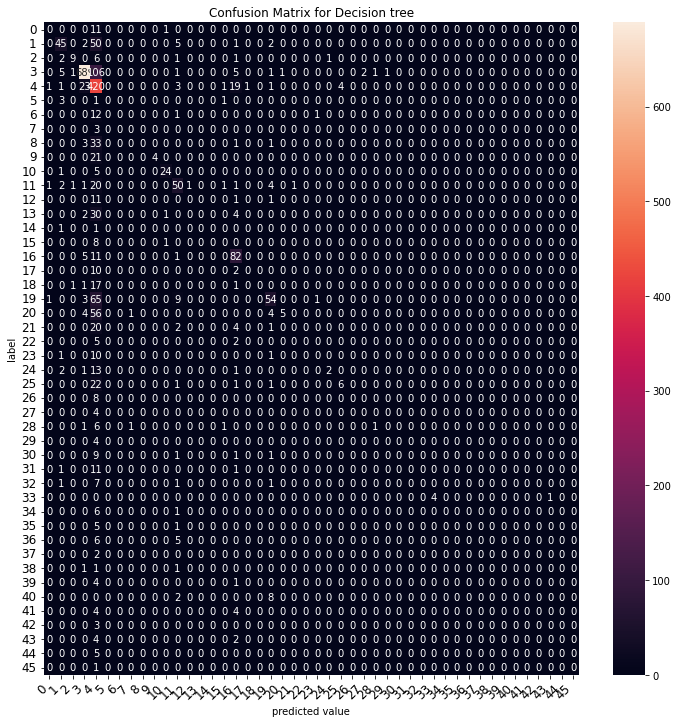

Training and evaluating Random Forest...
Random Forest 정확도: 0.6544968833481746
Random Forest F1 Score: 0.6225909375608356


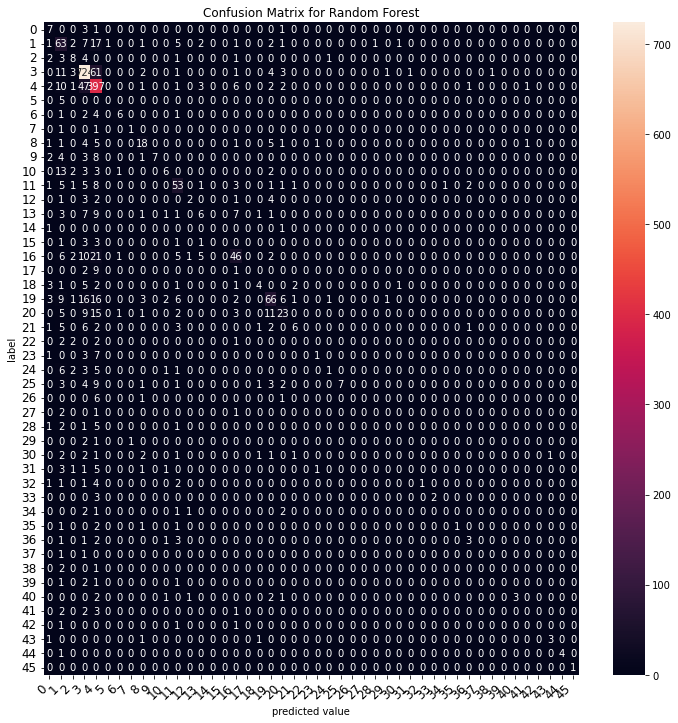

Training and evaluating Gradient Boosting tree...
      Iter       Train Loss   Remaining Time 
         1           1.4301           17.57m
         2       76760.8864           17.64m
         3   766490025.2967           17.43m
         4 660857139232122368.0000           17.29m
         5 1006529060407114004275646732312951615311370376755613476759245377256674837692003341988813591601665584394912965173495998495951159296.0000           17.14m
         6 1006529060407114004275646732312951615311370376755613476759245377256674837692003341988813591601665584394912965173495998495951159296.0000           16.91m
         7 1006529060407114004275646732312951615311370376755613476759245377256674837692003341988813591601665584394912965173495998495951159296.0000           16.74m
         8 1006529060407114004275646732312951615311370376755613476759245377256674837692003341988813591601665584394912965173495998495951159296.0000           16.54m
         9 10065290604071140042756467323129516153113703767556

        52 7935486330861459413268209935908863185564832687635547920920276400843855648137909550861590845608894276096734983386906163942311234165539923296256.0000            8.47m
        53 7935486330861459413268209935908863185564832687635547920920276400843855648137909550861590845608894276096734983386906163942311234165539923296256.0000            8.29m
        54 7935486330861459413268209935908863185564832687635547920920276400843855648137909550861590845608894276096734983386906163942311234165539923296256.0000            8.10m
        55 7935486330861459413268209935908863185564832687635547920920276400843855648137909550861590845608894276096734983386906163942311234165539923296256.0000            7.92m
        56 7935486330861459413268209935908863185564832687635547920920276400843855648137909550861590845608894276096734983386906163942311234165539923296256.0000            7.74m
        57 7935486330861459413268209935908863185564832687635547920920276400843855648137909550861590845608894276096734983

        99 7935486330861459413268209935908863185564832687635547920920276400843855648137909550861590845608894276096734983386906163942311234165539923296256.0000           10.32s
       100 7935486330861459413268209935908863185564832687635547920920276400843855648137909550861590845608894276096734983386906163942311234165539923296256.0000            0.00s
Gradient Boosting tree 정확도: 0.7702582368655387
Gradient Boosting tree F1 Score: 0.7641672650539437


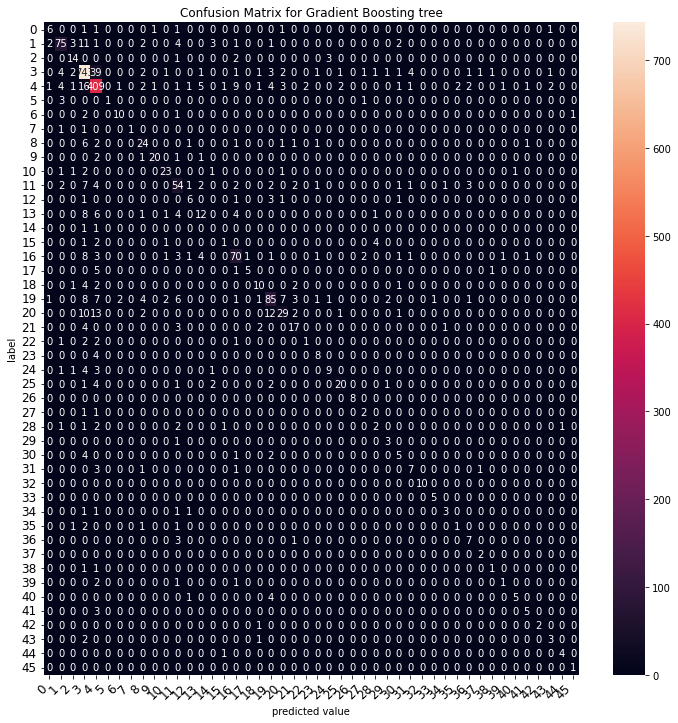

Training and evaluating Voting...


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Voting 정확도: 0.8161175422974176
Voting F1 Score: 0.8120699741800014


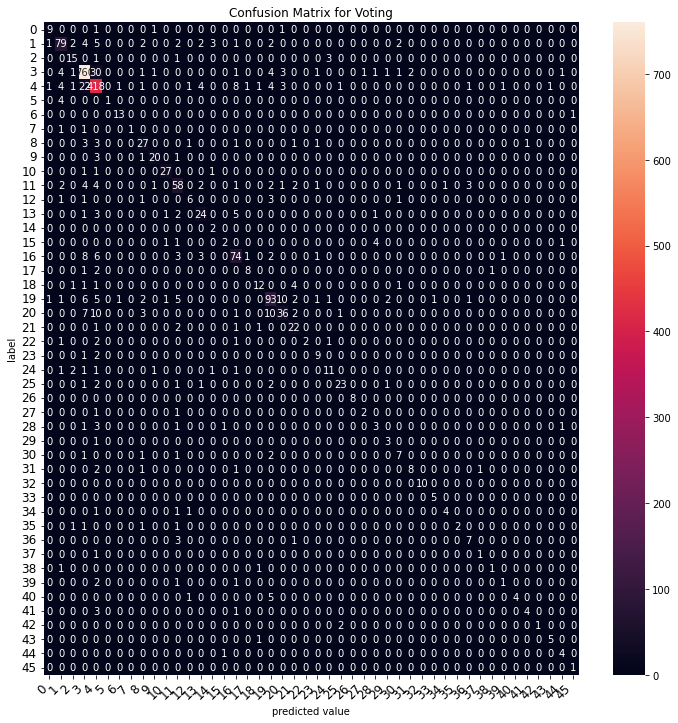

In [19]:
trained_models_all = train_ml(tfidfv, y_train, tfidfv_test, y_test)

In [20]:
nb_all, cnb_all, logreg_all, lsvm_all, dtree_all, rf_all, gbt_all, voting_all = trained_models_all

In [21]:
#5k

(x_train_5k, y_train_5k), (x_test_5k, y_test_5k) = reuters.load_data(num_words=5000, test_split=0.2)

In [22]:
x_train_5k = decode_data(x_train_5k, index_to_word)
x_test_5k = decode_data(x_test_5k, index_to_word)

In [23]:
dtmvector = CountVectorizer()
x_train_dtm_5k = dtmvector.fit_transform(x_train_5k)
print(x_train_dtm_5k.shape)


(8982, 4867)


In [24]:
tfidf_transformer = TfidfTransformer()
tfidfv_5k = tfidf_transformer.fit_transform(x_train_dtm_5k)
print(tfidfv_5k.shape)

(8982, 4867)


In [25]:
x_test_dtm_5k = dtmvector.transform(x_test_5k) # 테스트 데이터를 DTM으로 변환
tfidfv_test_5k = tfidf_transformer.transform(x_test_dtm_5k) # DTM을 TF-IDF 행렬로 변환

Training and evaluating Naive Bayesian...
Naive Bayesian 정확도: 0.6731967943009796
Naive Bayesian F1 Score: 0.6012501291711391


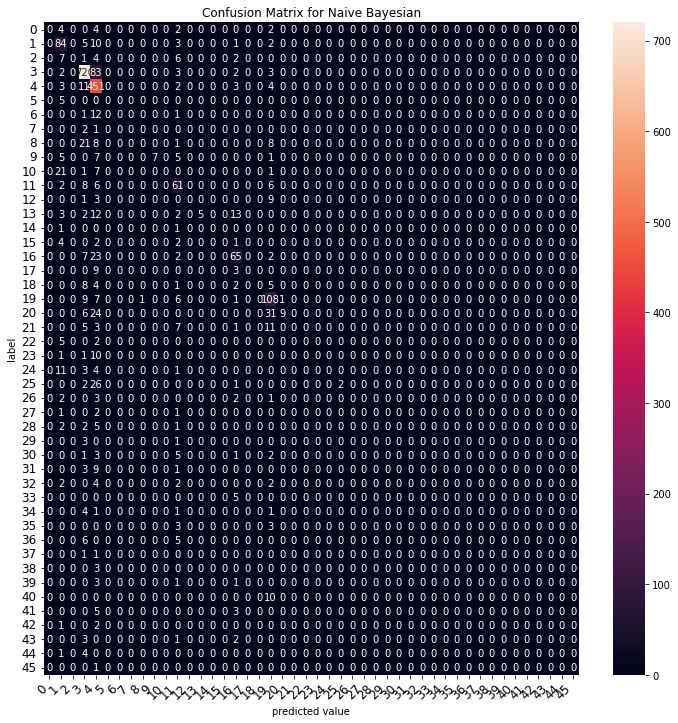

Training and evaluating CNB...
CNB 정확도: 0.7707034728406055
CNB F1 Score: 0.7458990404916549


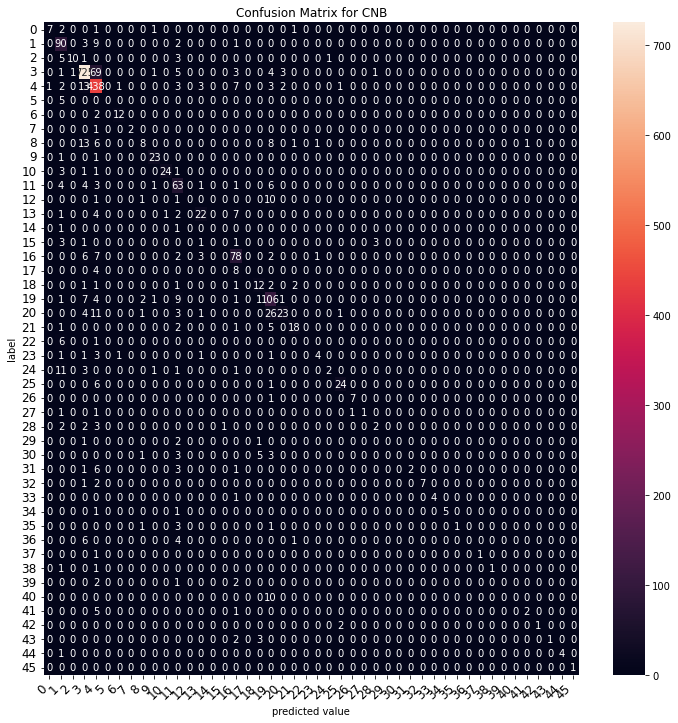

Training and evaluating Logistic Regression...


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression 정확도: 0.8054318788958148
Logistic Regression F1 Score: 0.800611258671043


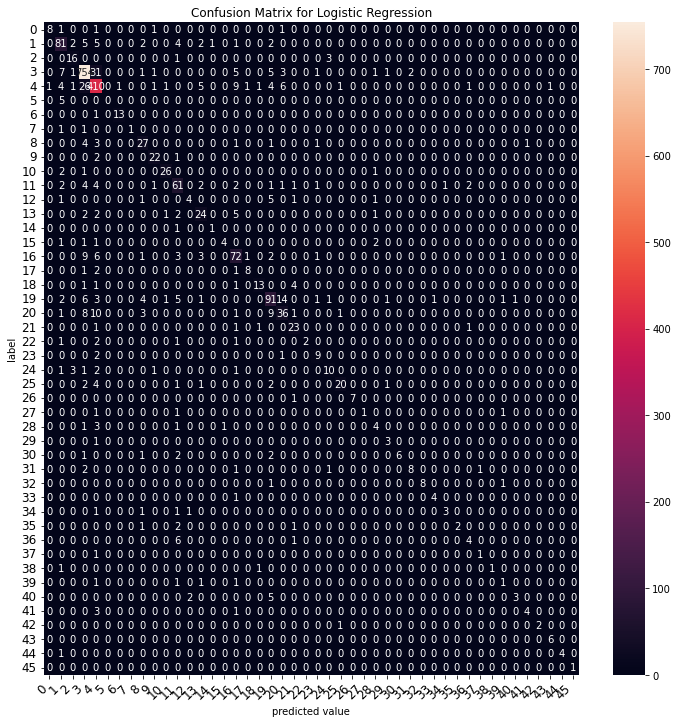

Training and evaluating Linear SVM...


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Linear SVM 정확도: 0.761353517364203
Linear SVM F1 Score: 0.7561163936127209


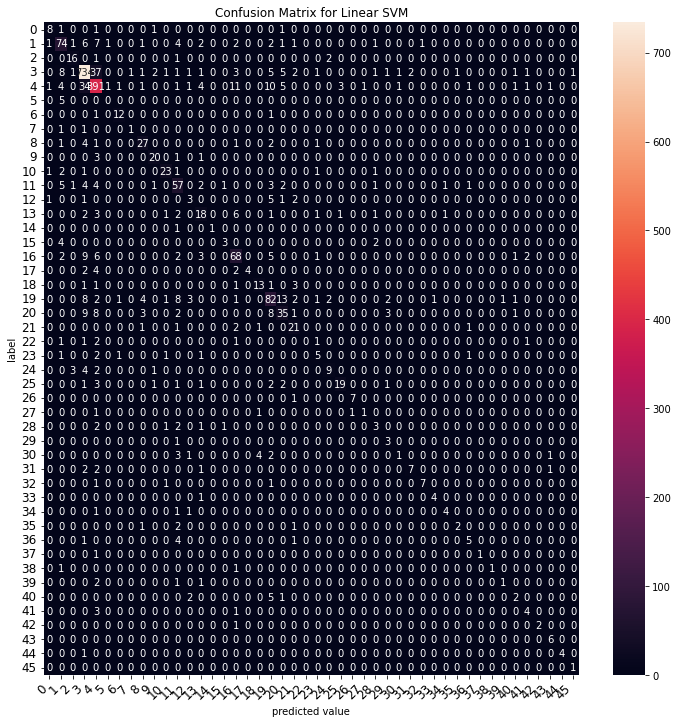

Training and evaluating Decision tree...
Decision tree 정확도: 0.6179875333926982
Decision tree F1 Score: 0.5729970881280324


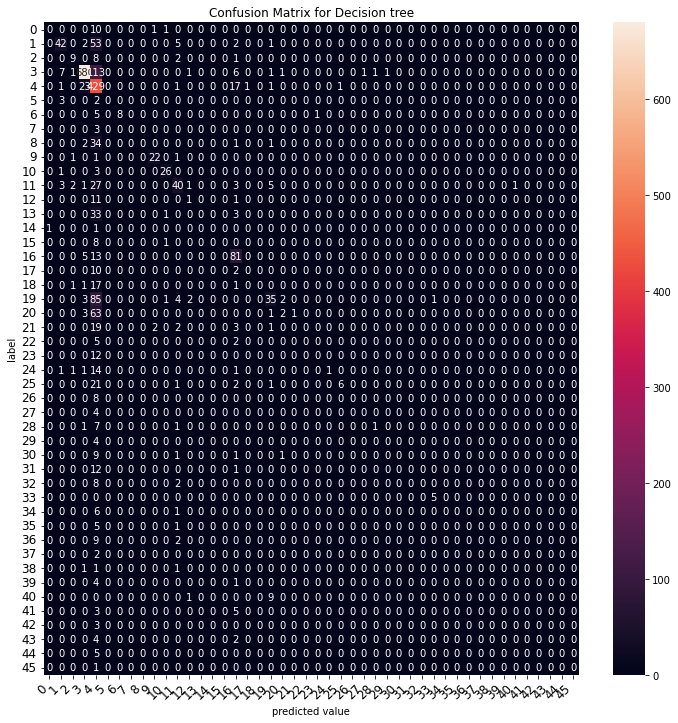

Training and evaluating Random Forest...
Random Forest 정확도: 0.701246660730187
Random Forest F1 Score: 0.6770217603524399


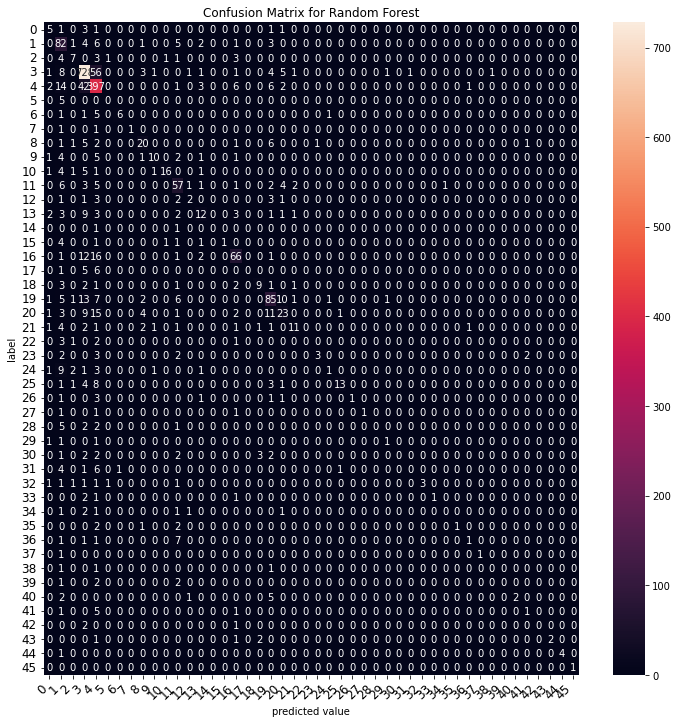

Training and evaluating Gradient Boosting tree...
      Iter       Train Loss   Remaining Time 
         1           1.4697           14.44m
         2     2131099.0239           14.43m
         3 113352934366748750033493137947714414201794552363528671409179356940992512.0000           14.31m
         4 645005367195105573487290209089081189090170195029150070319832395667206596719018218881024.0000           14.21m
         5 443067299530301659980374363525949995629695549691559890285869350923592723545213280554158712204202745088665306932510573934053386280801140736.0000           14.07m
         6 443067299530301659980374363525949995629695549691559890285869350923592723545213280554158712204202745088665306932510573934053386280801140736.0000           13.94m
         7 443067299530301659980374363525949995629695549691559890285869350923592723545213280554158712204202745088665306932510573934053386280801140736.0000           13.78m
         8 443067299530301659980374363525949995629695549691559890285869

        51 443067299530302073140354857431324340576763070173459783038796203599354776450710327057778234898793885831921831754563603678560901920400080896.0000            7.28m
        52 443067299530302073140354857431324340576763070173459783038796203599354776450710327057778234898793885831921831754563603678560901920400080896.0000            7.13m
        53 443067299530302073140354857431324340576763070173459783038796203599354776450710327057778234898793885831921831754563603678560901920400080896.0000            6.98m
        54 443067299530302073140354857431324340576763070173459783038796203599354776450710327057778234898793885831921831754563603678560901920400080896.0000            6.83m
        55 443067299530302073140354857431324340576763070173459783038796203599354776450710327057778234898793885831921831754563603678560901920400080896.0000            6.68m
        56 443067299530302073140354857431324340576763070173459783038796203599354776450710327057778234898793885831921831754563603678560901920

        99 443067299530302073140354857431324340576763070173459783038796203599354776450710327057778234898793885831921831754563603678560901920400080896.0000            8.88s
       100 443067299530302073140354857431324340576763070173459783038796203599354776450710327057778234898793885831921831754563603678560901920400080896.0000            0.00s
Gradient Boosting tree 정확도: 0.767586821015138
Gradient Boosting tree F1 Score: 0.7662475269931749


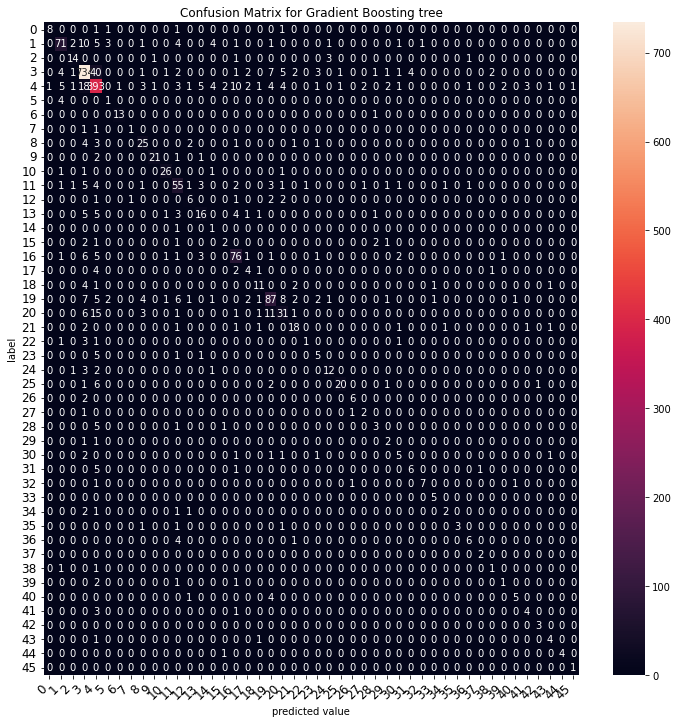

Training and evaluating Voting...


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Voting 정확도: 0.8116651825467498
Voting F1 Score: 0.8085626697774576


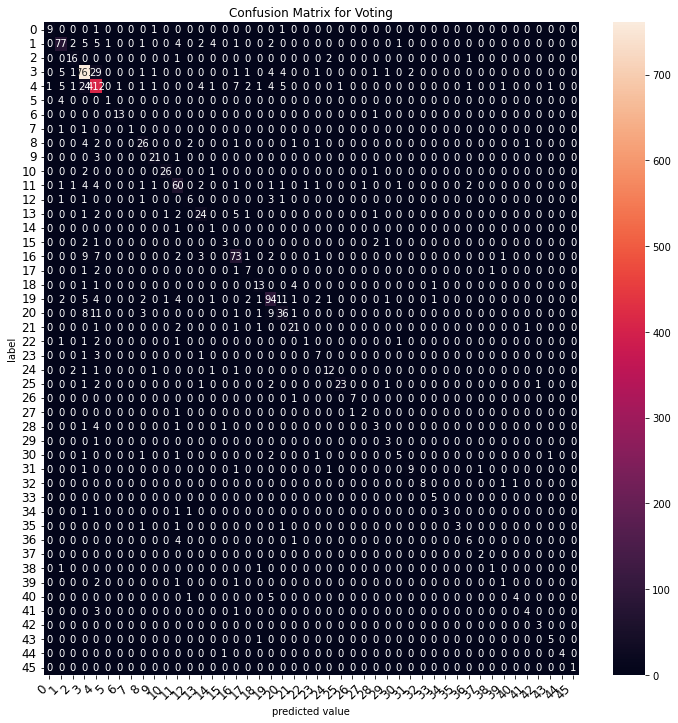

In [26]:
trained_models_5k = train_ml(tfidfv_5k, y_train_5k, tfidfv_test_5k, y_test_5k)

In [27]:
nb_5k, cnb_5k, logreg_5k, lsvm_5k, dtree_5k, rf_5k, gbt_5k, voting_5k = trained_models_5k

In [28]:
#3k

In [29]:
(x_train_3k, y_train_3k), (x_test_3k, y_test_3k) = reuters.load_data(num_words=3000, test_split=0.2)

In [30]:
x_train_3k = decode_data(x_train_3k, index_to_word)
x_test_3k = decode_data(x_test_3k, index_to_word)

In [31]:
dtmvector = CountVectorizer()
x_train_dtm_3k = dtmvector.fit_transform(x_train_3k)
print(x_train_dtm_3k.shape)


(8982, 2919)


In [32]:
tfidf_transformer = TfidfTransformer()
tfidfv_3k = tfidf_transformer.fit_transform(x_train_dtm_3k)
print(tfidfv_3k.shape)

(8982, 2919)


In [33]:
x_test_dtm_3k = dtmvector.transform(x_test_3k) # 테스트 데이터를 DTM으로 변환
tfidfv_test_3k = tfidf_transformer.transform(x_test_dtm_3k) # DTM을 TF-IDF 행렬로 변환

Training and evaluating Naive Bayesian...
Naive Bayesian 정확도: 0.6874443455031166
Naive Bayesian F1 Score: 0.6266168450864102


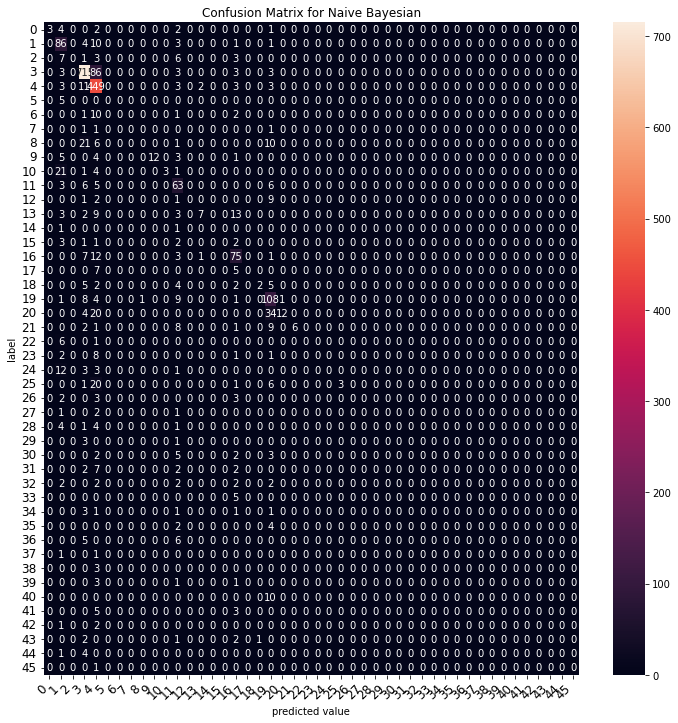

Training and evaluating CNB...
CNB 정확도: 0.7644701691896705
CNB F1 Score: 0.7369718160654114


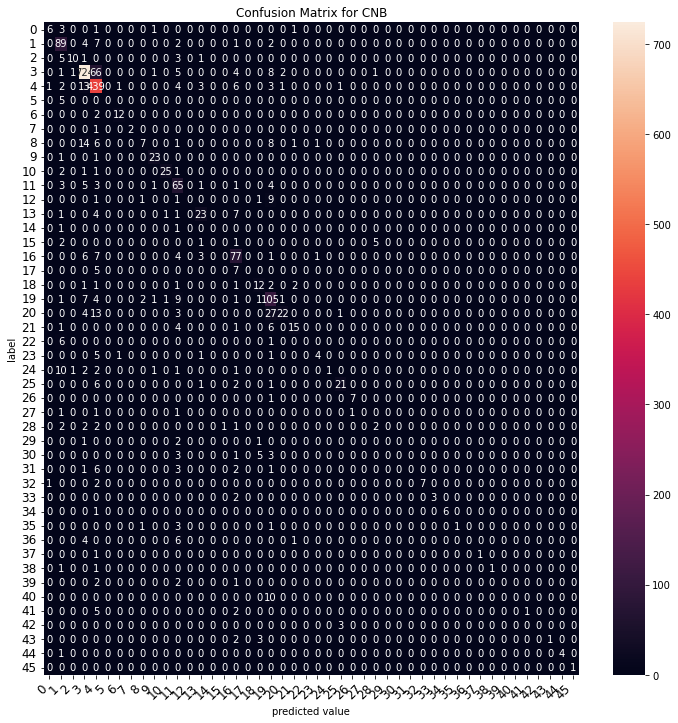

Training and evaluating Logistic Regression...


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression 정확도: 0.7898486197684773
Logistic Regression F1 Score: 0.7853329508421765


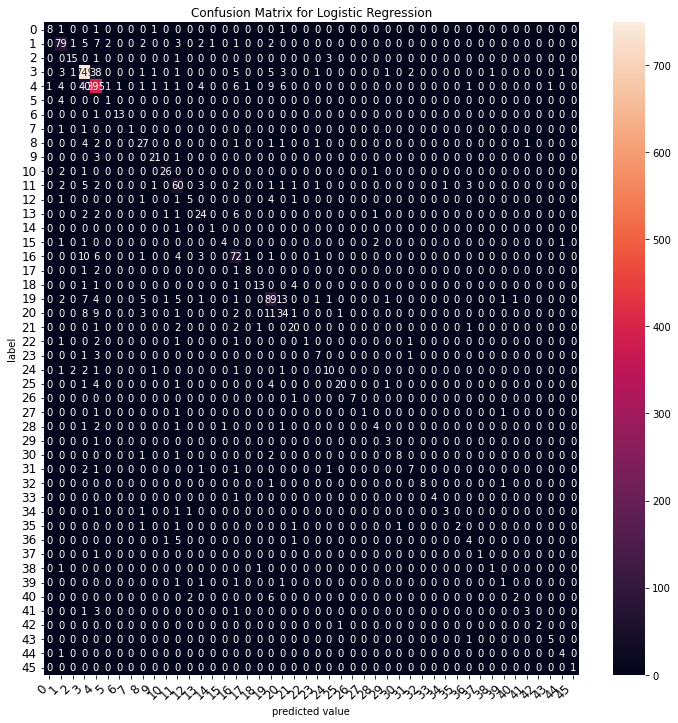

Training and evaluating Linear SVM...


/opt/conda/lib/python3.9/site-packages/sklearn/svm/_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Linear SVM 정확도: 0.7484416740872663
Linear SVM F1 Score: 0.7453471053331742


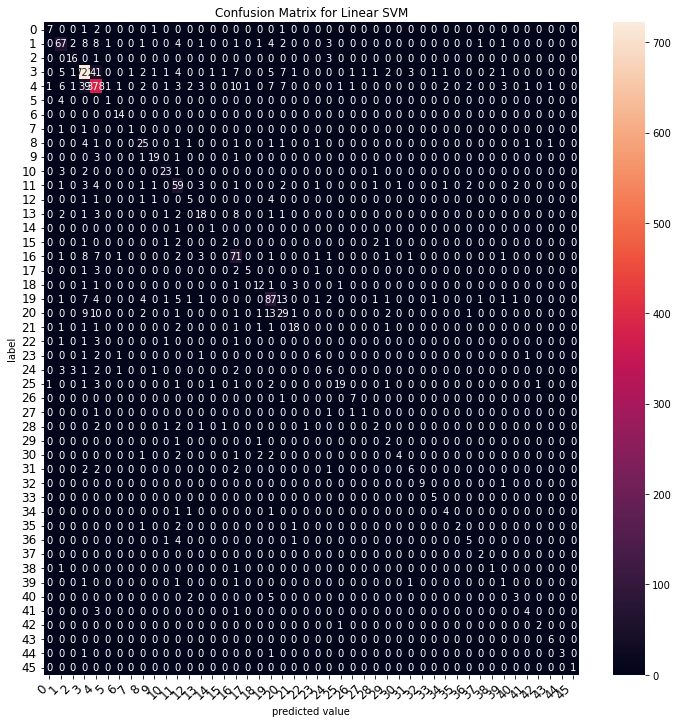

Training and evaluating Decision tree...
Decision tree 정확도: 0.6260017809439002
Decision tree F1 Score: 0.580006731123168


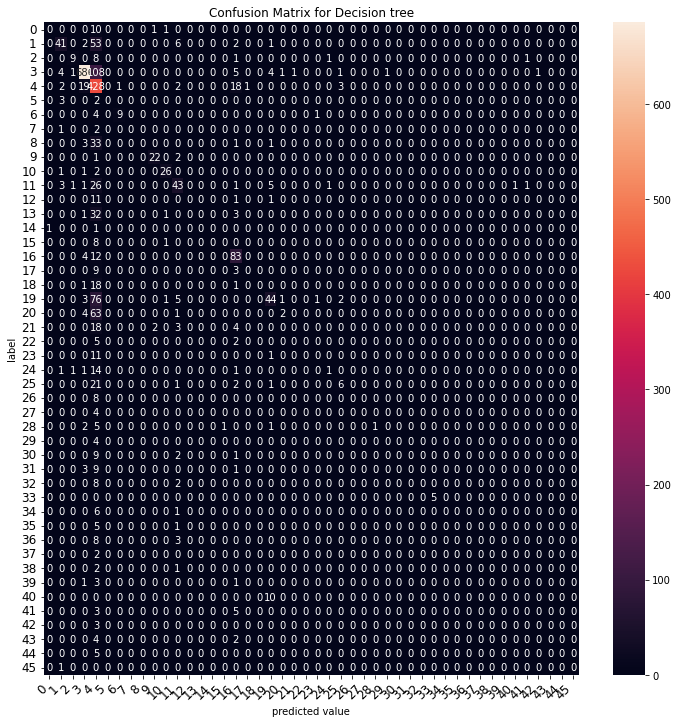

Training and evaluating Random Forest...
Random Forest 정확도: 0.6856634016028496
Random Forest F1 Score: 0.6591675010462239


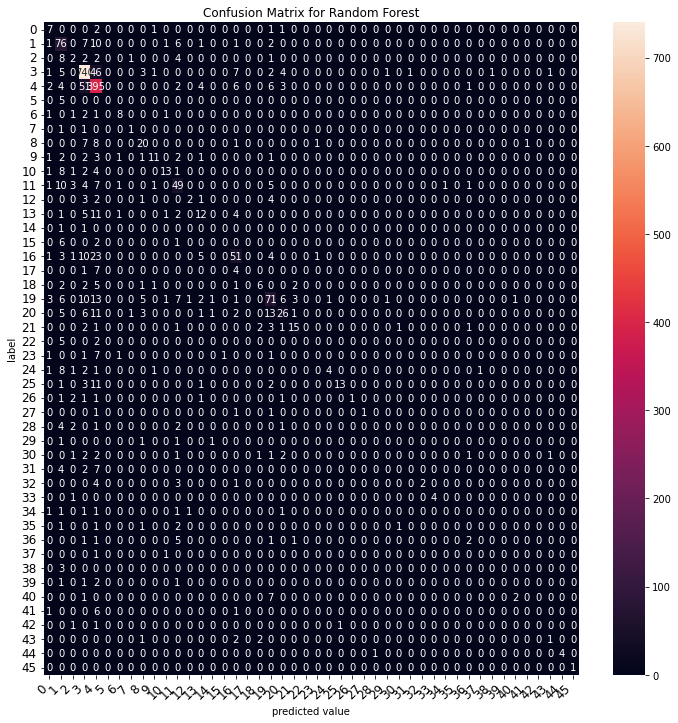

Training and evaluating Gradient Boosting tree...
      Iter       Train Loss   Remaining Time 
         1           1.4761           15.21m
         2       29810.4893           14.83m
         3 103018026703.3806           14.62m
         4 111593327959535219617691187806208.0000           14.44m
         5 1904496955476400955779467607778270076434921719903327597388087378686114846508037997135967451479015424.0000           14.41m
         6 235956225767185860904973188178954025040849742976577626543101088142147888944078511456039069709793443708307819607359488.0000           14.37m
         7 235956225767185860904973188178954025040849742976577626543101088142147888944078511456039069709793443708307819607359488.0000           14.26m
         8 235956225767185860904973188178954025040849742976577626543101088142147888944078511456039069709793443708307819607359488.0000           14.17m
         9 2359562257671858609049731881789540250408497429765776265431010881421478889440785114560390697097934437083

        57 40352158662156979707356448569843637020740653506984876608288956889514956281428182390728898507222354718197462518888103561386644209664.0000            6.37m
        58 40352158662156979707356448569843637020740653506984876608288956889514956281428182390728898507222354718197462518888103561386644209664.0000            6.22m
        59 40352158662156979707356448569843637020740653506984876608288956889514956281428182390728898507222354718197462518888103561386644209664.0000            6.07m
        60 40352158662156979707356448569843637020740653506984876608288956889514956281428182390728898507222354718197462518888103561386644209664.0000            5.92m
        61 40352158662156979707356448569843637020740653506984876608288956889514956281428182390728898507222354718197462518888103561386644209664.0000            5.77m
        62 40352158662156979707356448569843637020740653506984876608288956889514956281428182390728898507222354718197462518888103561386644209664.0000            5.62m
        63

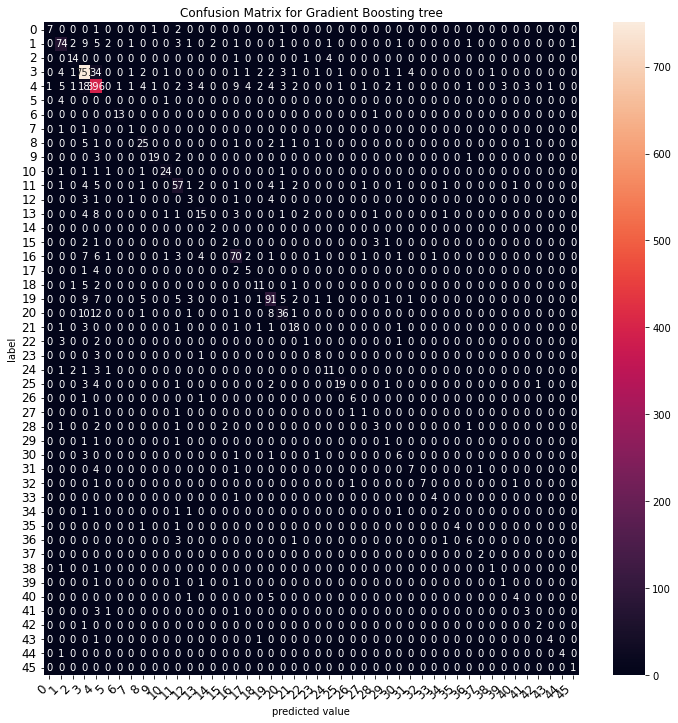

Training and evaluating Voting...


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Voting 정확도: 0.800979519145147
Voting F1 Score: 0.7970680420647528


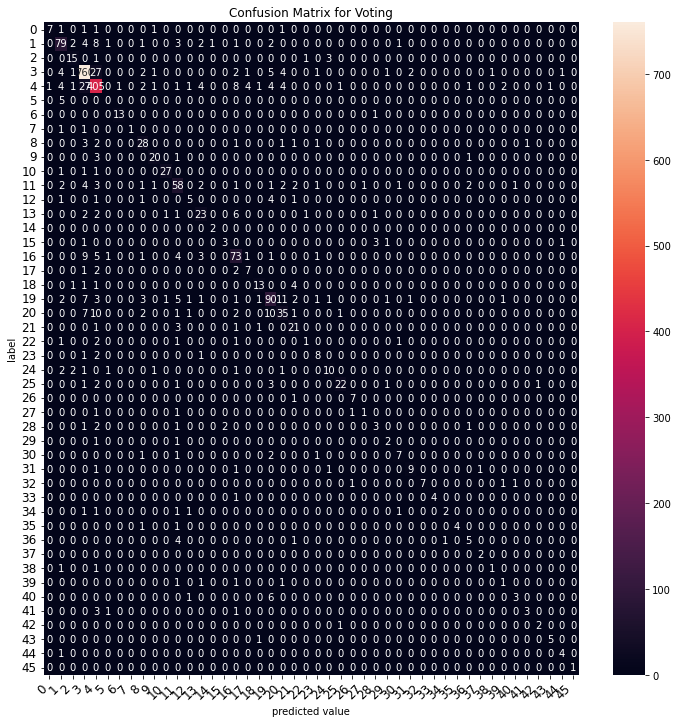

In [34]:
trained_models_3k = train_ml(tfidfv_3k, y_train_3k, tfidfv_test_3k, y_test_3k)

In [35]:
nb_3k, cnb_3k, logreg_3k, lsvm_3k, dtree_3k, rf_3k, gbt_3k, voting_3k = trained_models_3k

| *Num_words*        | 26.5k |       | 5k    |       | 3k    |       |
|---------------------|-------|-------|-------|-------|-------|-------|
|                     | **ACC(%)**   | **F1(%)**    | **ACC(%)**   | **F1(%)**    | **ACC(%)**   | **F1(%)**    |
| NB                  | 59.97 | 50.46 | 67.32 | 60.13 | 68.74 | 62.66 |
| CNB                 | 76.49 | 73.47 | 77.07 | 74.59 | 76.45 | 73.7  |
| **Logistic Regression** | **81.61** | **81.11** | **80.54** | **80.06** | 78.98 | 78.53 |
| Linear SVM          | 77.78 | 77.27 | 76.14 | 75.61 | 74.84 | 74.53 |
| Dicision tree       | 62.11 | 57.69 | 61.8  | 57.3  | 62.6  | 58    |
| Random Forest       | 65.45 | 62.26 | 70.12 | 67.7  | 68.57 | 65.92 |
| GBT                 | 77.03 | 76.42 | 76.76 | 76362 | 77.56 | 77.21 |
| **Voting**             | **81.61** | **81.27** | **81.17** | **80.86** | **80.1**  | 79.71 |

 Over 80% cases: Logistic Regression(num_words = 26.5k, 5k), Voting(num_words = 26.5k, 5k, 3k(F1 score lesser than 80%)
 
 Best case: Voting(num_words = 26.5k) - ACC: 81.61%, F1: 81.27%

## Compare with Deep Learning

In [1]:
from tensorflow.keras.datasets import reuters
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [13]:
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=None, test_split=0.2)

In [3]:
num_classes = max(y_train) + 1

In [4]:
word_index = reuters.get_word_index(path="reuters_word_index.json")

565248/550378 [==============================] - 0s 0us/step


In [5]:
index_to_word = {index + 3 : word for word, index in word_index.items()}

In [6]:
for index, token in enumerate(("<pad>", "<sos>", "<unk>")):
  index_to_word[index]=token

In [14]:
import tensorflow as tf
from tensorflow import keras


vocab_size = len(index_to_word) + 1  # +1 for out of vocabulary words
word_vector_dim = 16  # Word embedding dimension
maxlen = 200  # Maximum length of input sequences

# Padding the sequences to ensure uniform length
x_train_pad = keras.preprocessing.sequence.pad_sequences(x_train, padding='post', maxlen=maxlen)
x_test_pad = keras.preprocessing.sequence.pad_sequences(x_test, padding='post', maxlen=maxlen)

# Define the LSTM model
def build_lstm_model():
    model = keras.Sequential()
    model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(maxlen,)))
    model.add(keras.layers.LSTM(32))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dense(num_classes, activation='softmax'))
    return model

model_LSTM = build_lstm_model()
model_LSTM.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 16)           495728    
_________________________________________________________________
lstm (LSTM)                  (None, 32)                6272      
_________________________________________________________________
dense (Dense)                (None, 128)               4224      
_________________________________________________________________
dense_1 (Dense)              (None, 46)                5934      
Total params: 512,158
Trainable params: 512,158
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Setting Early Stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

# Compile the LSTM model
model_LSTM.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with 30 epochs and apply early stopping
history = model_LSTM.fit(x_train_pad, y_train, epochs=30, validation_data=(x_test_pad, y_test), callbacks=[early_stopping])


Epoch 1/30
281/281 [==============================] - 33s 11ms/step - loss: 2.5132 - accuracy: 0.3517 - val_loss: 2.3674 - val_accuracy: 0.3682
Epoch 2/30
281/281 [==============================] - 2s 8ms/step - loss: 2.3412 - accuracy: 0.3624 - val_loss: 2.4048 - val_accuracy: 0.3620
Epoch 3/30
281/281 [==============================] - 2s 8ms/step - loss: 2.3498 - accuracy: 0.3552 - val_loss: 2.3676 - val_accuracy: 0.3713


In [16]:
word_vector_dim = 32  # Word embedding dimension


model_LSTM2 = build_lstm_model()
model_LSTM2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 32)           991456    
_________________________________________________________________
lstm_1 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               4224      
_________________________________________________________________
dense_3 (Dense)              (None, 46)                5934      
Total params: 1,009,934
Trainable params: 1,009,934
Non-trainable params: 0
_________________________________________________________________


In [17]:
model_LSTM2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with 30 epochs and apply early stopping
history = model_LSTM2.fit(x_train_pad, y_train, epochs=30, validation_data=(x_test_pad, y_test), callbacks=[early_stopping])

Epoch 1/30
281/281 [==============================] - 4s 10ms/step - loss: 2.5031 - accuracy: 0.3547 - val_loss: 2.3534 - val_accuracy: 0.3709
Epoch 2/30
281/281 [==============================] - 2s 8ms/step - loss: 2.3682 - accuracy: 0.3536 - val_loss: 2.3597 - val_accuracy: 0.3762
Epoch 3/30
281/281 [==============================] - 2s 8ms/step - loss: 2.2112 - accuracy: 0.3796 - val_loss: 2.0528 - val_accuracy: 0.4038
Epoch 4/30
281/281 [==============================] - 2s 8ms/step - loss: 2.1027 - accuracy: 0.3959 - val_loss: 2.4172 - val_accuracy: 0.3629
Epoch 5/30
281/281 [==============================] - 2s 8ms/step - loss: 2.3313 - accuracy: 0.3673 - val_loss: 2.3252 - val_accuracy: 0.3842


In [18]:
word_vector_dim = 64  # Word embedding dimension


model_LSTM3 = build_lstm_model()
model_LSTM3.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 64)           1982912   
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               4224      
_________________________________________________________________
dense_5 (Dense)              (None, 46)                5934      
Total params: 2,005,486
Trainable params: 2,005,486
Non-trainable params: 0
_________________________________________________________________


In [19]:
model_LSTM3.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with 30 epochs and apply early stopping
history = model_LSTM3.fit(x_train_pad, y_train, epochs=30, validation_data=(x_test_pad, y_test), callbacks=[early_stopping])

Epoch 1/30
281/281 [==============================] - 4s 10ms/step - loss: 2.5100 - accuracy: 0.3449 - val_loss: 2.3676 - val_accuracy: 0.3704
Epoch 2/30
281/281 [==============================] - 2s 8ms/step - loss: 2.2695 - accuracy: 0.3673 - val_loss: 2.1304 - val_accuracy: 0.4101
Epoch 3/30
281/281 [==============================] - 2s 8ms/step - loss: 2.0970 - accuracy: 0.4095 - val_loss: 2.0611 - val_accuracy: 0.4056
Epoch 4/30
281/281 [==============================] - 2s 8ms/step - loss: 2.0457 - accuracy: 0.3994 - val_loss: 2.0394 - val_accuracy: 0.3918
Epoch 5/30
281/281 [==============================] - 2s 9ms/step - loss: 2.2430 - accuracy: 0.3853 - val_loss: 2.3037 - val_accuracy: 0.3891
Epoch 6/30
281/281 [==============================] - 2s 9ms/step - loss: 2.1236 - accuracy: 0.4060 - val_loss: 2.0570 - val_accuracy: 0.4216


In [20]:
word_vector_dim = 128  # Word embedding dimension


model_LSTM4 = build_lstm_model()
model_LSTM4.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 128)          3965824   
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                20608     
_________________________________________________________________
dense_6 (Dense)              (None, 128)               4224      
_________________________________________________________________
dense_7 (Dense)              (None, 46)                5934      
Total params: 3,996,590
Trainable params: 3,996,590
Non-trainable params: 0
_________________________________________________________________


In [21]:
model_LSTM4.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with 30 epochs and apply early stopping
history = model_LSTM4.fit(x_train_pad, y_train, epochs=30, validation_data=(x_test_pad, y_test), callbacks=[early_stopping])

Epoch 1/30
281/281 [==============================] - 4s 11ms/step - loss: 2.4743 - accuracy: 0.3573 - val_loss: 2.3305 - val_accuracy: 0.3829
Epoch 2/30
281/281 [==============================] - 3s 9ms/step - loss: 2.1972 - accuracy: 0.3752 - val_loss: 2.3584 - val_accuracy: 0.3629
Epoch 3/30
281/281 [==============================] - 3s 9ms/step - loss: 2.1480 - accuracy: 0.3840 - val_loss: 2.1013 - val_accuracy: 0.3963
Epoch 4/30
281/281 [==============================] - 3s 9ms/step - loss: 2.0588 - accuracy: 0.4333 - val_loss: 2.1259 - val_accuracy: 0.4341
Epoch 5/30
281/281 [==============================] - 3s 9ms/step - loss: 1.9766 - accuracy: 0.4214 - val_loss: 2.0925 - val_accuracy: 0.3847
Epoch 6/30
281/281 [==============================] - 3s 9ms/step - loss: 2.1118 - accuracy: 0.3933 - val_loss: 2.1526 - val_accuracy: 0.3869
Epoch 7/30
281/281 [==============================] - 3s 9ms/step - loss: 1.9275 - accuracy: 0.4227 - val_loss: 2.2376 - val_accuracy: 0.3856


In [26]:
word_vector_dim = 256  # Word embedding dimension


model_LSTM5 = build_lstm_model()
model_LSTM5.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 200, 256)          7931648   
_________________________________________________________________
lstm_6 (LSTM)                (None, 32)                36992     
_________________________________________________________________
dense_12 (Dense)             (None, 128)               4224      
_________________________________________________________________
dense_13 (Dense)             (None, 46)                5934      
Total params: 7,978,798
Trainable params: 7,978,798
Non-trainable params: 0
_________________________________________________________________


In [27]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

model_LSTM5.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with 30 epochs and apply early stopping
history = model_LSTM5.fit(x_train_pad, y_train, epochs=30, validation_data=(x_test_pad, y_test), callbacks=[early_stopping])

Epoch 1/30
281/281 [==============================] - 5s 13ms/step - loss: 2.4587 - accuracy: 0.3528 - val_loss: 2.3691 - val_accuracy: 0.3678
Epoch 2/30
281/281 [==============================] - 3s 11ms/step - loss: 2.2047 - accuracy: 0.3706 - val_loss: 2.0480 - val_accuracy: 0.4074
Epoch 3/30
281/281 [==============================] - 3s 11ms/step - loss: 2.0688 - accuracy: 0.4221 - val_loss: 2.0424 - val_accuracy: 0.4452
Epoch 4/30
281/281 [==============================] - 3s 11ms/step - loss: 1.9419 - accuracy: 0.4460 - val_loss: 2.0581 - val_accuracy: 0.4386
Epoch 5/30
281/281 [==============================] - 3s 11ms/step - loss: 1.8779 - accuracy: 0.4509 - val_loss: 2.1083 - val_accuracy: 0.4074
Epoch 6/30
281/281 [==============================] - 3s 11ms/step - loss: 1.7952 - accuracy: 0.4655 - val_loss: 2.0968 - val_accuracy: 0.4274
Epoch 7/30
281/281 [==============================] - 3s 11ms/step - loss: 1.8461 - accuracy: 0.4572 - val_loss: 2.1464 - val_accuracy: 0.4256

In [28]:
word_vector_dim = 512  # Word embedding dimension


model_LSTM6 = build_lstm_model()
model_LSTM6.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 200, 512)          15863296  
_________________________________________________________________
lstm_7 (LSTM)                (None, 32)                69760     
_________________________________________________________________
dense_14 (Dense)             (None, 128)               4224      
_________________________________________________________________
dense_15 (Dense)             (None, 46)                5934      
Total params: 15,943,214
Trainable params: 15,943,214
Non-trainable params: 0
_________________________________________________________________


In [30]:
model_LSTM6.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with 30 epochs and apply early stopping
history = model_LSTM6.fit(x_train_pad, y_train, epochs=30, validation_data=(x_test_pad, y_test), callbacks=[early_stopping])

Epoch 1/30
281/281 [==============================] - 6s 17ms/step - loss: 2.3911 - accuracy: 0.3629 - val_loss: 2.0379 - val_accuracy: 0.3967
Epoch 2/30
281/281 [==============================] - 4s 16ms/step - loss: 2.0790 - accuracy: 0.3937 - val_loss: 2.2438 - val_accuracy: 0.3949
Epoch 3/30
281/281 [==============================] - 5s 16ms/step - loss: 2.0464 - accuracy: 0.4026 - val_loss: 2.0329 - val_accuracy: 0.4132
Epoch 4/30
281/281 [==============================] - 4s 16ms/step - loss: 1.9355 - accuracy: 0.4279 - val_loss: 2.0187 - val_accuracy: 0.4083
Epoch 5/30
281/281 [==============================] - 5s 16ms/step - loss: 1.7940 - accuracy: 0.4610 - val_loss: 2.0594 - val_accuracy: 0.4546
Epoch 6/30
281/281 [==============================] - 4s 16ms/step - loss: 1.5490 - accuracy: 0.5947 - val_loss: 1.6745 - val_accuracy: 0.6024
Epoch 7/30
281/281 [==============================] - 5s 16ms/step - loss: 1.2643 - accuracy: 0.6839 - val_loss: 1.6683 - val_accuracy: 0.6051

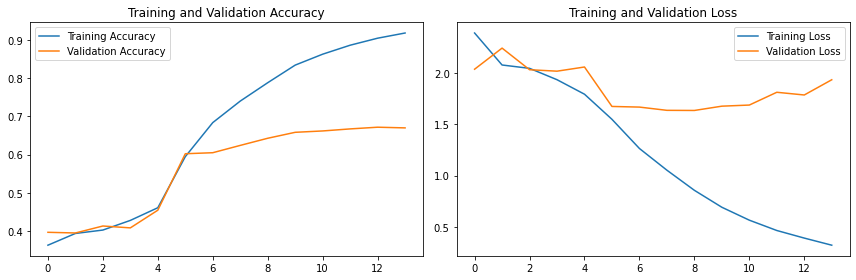

In [31]:
import matplotlib.pyplot as plt

# Plotting accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


## Overfitting happened with shallow model -> need deeper model

In [32]:
def build_deeper_lstm_model():
    model = keras.Sequential()
    
    # Embedding layer
    model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(maxlen,)))
    
    # 1st LSTM layer with return_sequences=True for stacking
    model.add(keras.layers.LSTM(32, return_sequences=True))
    model.add(keras.layers.Dropout(0.3))  # Dropout for regularization
    
    # 2nd LSTM layer
    model.add(keras.layers.LSTM(32))
    model.add(keras.layers.Dropout(0.3))  # Dropout for regularization
    
    # Dense layers
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(0.3))  # Dropout for regularization
    
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))  # Dropout for regularization
    
    # Output layer
    model.add(keras.layers.Dense(num_classes, activation='softmax'))
    
    return model



In [33]:
word_vector_dim = 512  # Word embedding dimension


model_LSTM7 = build_deeper_lstm_model()
model_LSTM7.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 200, 512)          15863296  
_________________________________________________________________
lstm_8 (LSTM)                (None, 200, 32)           69760     
_________________________________________________________________
dropout (Dropout)            (None, 200, 32)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_16 (Dense)             (None, 128)               4224      
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

In [34]:
model_LSTM7.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with 30 epochs and apply early stopping
history = model_LSTM7.fit(x_train_pad, y_train, epochs=30, validation_data=(x_test_pad, y_test), callbacks=[early_stopping])

Epoch 1/30
281/281 [==============================] - 10s 24ms/step - loss: 2.5865 - accuracy: 0.3307 - val_loss: 2.3624 - val_accuracy: 0.3620
Epoch 2/30
281/281 [==============================] - 6s 21ms/step - loss: 2.3374 - accuracy: 0.3515 - val_loss: 2.1147 - val_accuracy: 0.4368
Epoch 3/30
281/281 [==============================] - 6s 21ms/step - loss: 2.0637 - accuracy: 0.3712 - val_loss: 2.0460 - val_accuracy: 0.3798
Epoch 4/30
281/281 [==============================] - 6s 21ms/step - loss: 1.9726 - accuracy: 0.3943 - val_loss: 2.0119 - val_accuracy: 0.4016
Epoch 5/30
281/281 [==============================] - 6s 21ms/step - loss: 1.9709 - accuracy: 0.4096 - val_loss: 2.0787 - val_accuracy: 0.4150
Epoch 6/30
281/281 [==============================] - 6s 21ms/step - loss: 1.9079 - accuracy: 0.4293 - val_loss: 2.0882 - val_accuracy: 0.4154
Epoch 7/30
281/281 [==============================] - 6s 21ms/step - loss: 1.8701 - accuracy: 0.4501 - val_loss: 2.0772 - val_accuracy: 0.401

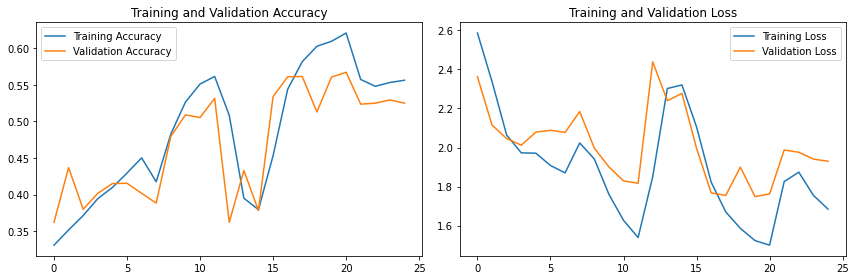

In [35]:
import matplotlib.pyplot as plt

# Plotting accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()


In [36]:
word_vector_dim = 256  # Word embedding dimension


model_LSTM8 = build_deeper_lstm_model()
model_LSTM8.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 200, 256)          7931648   
_________________________________________________________________
lstm_10 (LSTM)               (None, 200, 32)           36992     
_________________________________________________________________
dropout_4 (Dropout)          (None, 200, 32)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 128)               4224      
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)              

In [37]:
model_LSTM8.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with 30 epochs and apply early stopping
history = model_LSTM8.fit(x_train_pad, y_train, epochs=30, validation_data=(x_test_pad, y_test), callbacks=[early_stopping])

Epoch 1/30
281/281 [==============================] - 8s 19ms/step - loss: 2.6119 - accuracy: 0.3196 - val_loss: 2.3560 - val_accuracy: 0.3620
Epoch 2/30
281/281 [==============================] - 5s 17ms/step - loss: 2.1874 - accuracy: 0.3513 - val_loss: 2.4001 - val_accuracy: 0.3620
Epoch 3/30
281/281 [==============================] - 5s 16ms/step - loss: 2.2223 - accuracy: 0.3623 - val_loss: 2.0914 - val_accuracy: 0.3651
Epoch 4/30
281/281 [==============================] - 5s 17ms/step - loss: 2.3254 - accuracy: 0.3513 - val_loss: 2.4013 - val_accuracy: 0.3633
Epoch 5/30
281/281 [==============================] - 5s 16ms/step - loss: 2.3568 - accuracy: 0.3680 - val_loss: 2.3599 - val_accuracy: 0.3865
Epoch 6/30
281/281 [==============================] - 5s 17ms/step - loss: 2.2146 - accuracy: 0.3687 - val_loss: 2.4499 - val_accuracy: 0.3615
Epoch 7/30
281/281 [==============================] - 5s 16ms/step - loss: 2.4414 - accuracy: 0.3511 - val_loss: 2.4604 - val_accuracy: 0.3620

In [38]:
def build_less_deeper_lstm_model():
    model = keras.Sequential()
    
    # Embedding layer
    model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(maxlen,)))
    
    # 1st LSTM layer with return_sequences=True for stacking
    model.add(keras.layers.LSTM(32, return_sequences=True))
    
    # 2nd LSTM layer
    model.add(keras.layers.LSTM(32))
    
    # Dense layers
    model.add(keras.layers.Dense(128, activation='relu'))
    
    model.add(keras.layers.Dense(64, activation='relu'))
    # Output layer
    model.add(keras.layers.Dense(num_classes, activation='softmax'))
    
    return model

In [39]:
word_vector_dim = 512  # Word embedding dimension


model_LSTM9 = build_less_deeper_lstm_model()
model_LSTM9.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 200, 512)          15863296  
_________________________________________________________________
lstm_12 (LSTM)               (None, 200, 32)           69760     
_________________________________________________________________
dropout_8 (Dropout)          (None, 200, 32)           0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_9 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_22 (Dense)             (None, 128)               4224      
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)             

In [40]:
model_LSTM9.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with 30 epochs and apply early stopping
history = model_LSTM9.fit(x_train_pad, y_train, epochs=30, validation_data=(x_test_pad, y_test), callbacks=[early_stopping])

Epoch 1/30
281/281 [==============================] - 9s 24ms/step - loss: 2.6065 - accuracy: 0.3267 - val_loss: 2.3632 - val_accuracy: 0.3620
Epoch 2/30
281/281 [==============================] - 6s 21ms/step - loss: 2.1850 - accuracy: 0.3703 - val_loss: 2.0229 - val_accuracy: 0.4016
Epoch 3/30
281/281 [==============================] - 6s 21ms/step - loss: 2.2736 - accuracy: 0.3533 - val_loss: 2.5520 - val_accuracy: 0.2106
Epoch 4/30
281/281 [==============================] - 6s 22ms/step - loss: 2.3388 - accuracy: 0.3559 - val_loss: 2.2653 - val_accuracy: 0.3816
Epoch 5/30
281/281 [==============================] - 6s 21ms/step - loss: 2.0721 - accuracy: 0.3812 - val_loss: 2.0329 - val_accuracy: 0.3927
Epoch 6/30
281/281 [==============================] - 6s 21ms/step - loss: 1.9618 - accuracy: 0.4008 - val_loss: 2.0241 - val_accuracy: 0.4029
Epoch 7/30
281/281 [==============================] - 6s 21ms/step - loss: 1.9247 - accuracy: 0.4035 - val_loss: 2.0347 - val_accuracy: 0.4043

In [41]:
def build_even_deeper_lstm_model():
    model = keras.Sequential()
    
    # Embedding layer
    model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(maxlen,)))
    
    # 1st LSTM layer with return_sequences=True for stacking
    model.add(keras.layers.LSTM(32, return_sequences=True))
    model.add(keras.layers.Dropout(0.3))  # Dropout for regularization
    
    # 2nd LSTM layer
    model.add(keras.layers.LSTM(32))
    model.add(keras.layers.Dropout(0.3))  # Dropout for regularization
    
    # Dense layers
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dropout(0.4))  # Dropout for regularization
    
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(0.4))  # Dropout for regularization
    
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.4))  # Dropout for regularization
    
    model.add(keras.layers.Dense(32, activation='relu'))
    model.add(keras.layers.Dropout(0.4))  # Dropout for regularization
    
    # Output layer
    model.add(keras.layers.Dense(num_classes, activation='softmax'))
    
    return model



In [44]:
word_vector_dim = 512  # Word embedding dimension


model_LSTM10 = build_even_deeper_lstm_model()
model_LSTM10.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 200, 512)          15863296  
_________________________________________________________________
lstm_16 (LSTM)               (None, 200, 32)           69760     
_________________________________________________________________
dropout_18 (Dropout)         (None, 200, 32)           0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_19 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_30 (Dense)             (None, 256)               8448      
_________________________________________________________________
dropout_20 (Dropout)         (None, 256)             

In [45]:
model_LSTM10.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with 30 epochs and apply early stopping
history = model_LSTM10.fit(x_train_pad, y_train, epochs=30, validation_data=(x_test_pad, y_test), callbacks=[early_stopping])

Epoch 1/30
281/281 [==============================] - 9s 24ms/step - loss: 2.7071 - accuracy: 0.2966 - val_loss: 2.2770 - val_accuracy: 0.3838
Epoch 2/30
281/281 [==============================] - 6s 21ms/step - loss: 2.3962 - accuracy: 0.3518 - val_loss: 2.3387 - val_accuracy: 0.3620
Epoch 3/30
281/281 [==============================] - 6s 21ms/step - loss: 2.4525 - accuracy: 0.3451 - val_loss: 2.3572 - val_accuracy: 0.3620
Epoch 4/30
281/281 [==============================] - 6s 21ms/step - loss: 2.4143 - accuracy: 0.3499 - val_loss: 2.3604 - val_accuracy: 0.3620
Epoch 5/30
281/281 [==============================] - 6s 21ms/step - loss: 2.3587 - accuracy: 0.3559 - val_loss: 2.2082 - val_accuracy: 0.3842
Epoch 6/30
281/281 [==============================] - 6s 22ms/step - loss: 2.2305 - accuracy: 0.3656 - val_loss: 2.3113 - val_accuracy: 0.3816
Epoch 7/30
281/281 [==============================] - 6s 22ms/step - loss: 2.1168 - accuracy: 0.3717 - val_loss: 2.0356 - val_accuracy: 0.3963

In [46]:
x_train_pad = keras.preprocessing.sequence.pad_sequences(x_train, padding='pre', maxlen=maxlen)
x_test_pad = keras.preprocessing.sequence.pad_sequences(x_test, padding='pre', maxlen=maxlen)

In [47]:
word_vector_dim = 512  # Word embedding dimension


model_LSTM11 = build_even_deeper_lstm_model()
model_LSTM11.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 200, 512)          15863296  
_________________________________________________________________
lstm_18 (LSTM)               (None, 200, 32)           69760     
_________________________________________________________________
dropout_24 (Dropout)         (None, 200, 32)           0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dropout_25 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_35 (Dense)             (None, 256)               8448      
_________________________________________________________________
dropout_26 (Dropout)         (None, 256)             

In [48]:
model_LSTM11.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with 30 epochs and apply early stopping
history = model_LSTM11.fit(x_train_pad, y_train, epochs=30, validation_data=(x_test_pad, y_test), callbacks=[early_stopping])

Epoch 1/30
281/281 [==============================] - 9s 24ms/step - loss: 2.3620 - accuracy: 0.3743 - val_loss: 1.8276 - val_accuracy: 0.5565
Epoch 2/30
281/281 [==============================] - 6s 21ms/step - loss: 1.8522 - accuracy: 0.5332 - val_loss: 1.8251 - val_accuracy: 0.5307
Epoch 3/30
281/281 [==============================] - 6s 21ms/step - loss: 1.6900 - accuracy: 0.5633 - val_loss: 1.6984 - val_accuracy: 0.5690
Epoch 4/30
281/281 [==============================] - 6s 21ms/step - loss: 1.5344 - accuracy: 0.5875 - val_loss: 1.7281 - val_accuracy: 0.5650
Epoch 5/30
281/281 [==============================] - 6s 21ms/step - loss: 1.4302 - accuracy: 0.6019 - val_loss: 1.7465 - val_accuracy: 0.5695
Epoch 6/30
281/281 [==============================] - 6s 22ms/step - loss: 1.3826 - accuracy: 0.6033 - val_loss: 1.8422 - val_accuracy: 0.5614
Epoch 7/30
281/281 [==============================] - 6s 21ms/step - loss: 1.3056 - accuracy: 0.6204 - val_loss: 2.0745 - val_accuracy: 0.5654

In [63]:
from tensorflow.keras.layers import Add, Input
from tensorflow.keras.models import Model

def build_residual_lstm_model():
    # Input layer
    inputs = Input(shape=(maxlen,))
    
    # Embedding layer
    embedded = keras.layers.Embedding(vocab_size, word_vector_dim)(inputs)
    
    # LSTM layers
    lstm_out1 = keras.layers.LSTM(32, return_sequences=True)(embedded)
    lstm_out2 = keras.layers.LSTM(32)(lstm_out1)
    
    # First set of Dense layers with skip connection
    dense1 = keras.layers.Dense(256, activation='relu')(lstm_out2)
    dense1 = keras.layers.Dropout(0.2)(dense1)
    
    dense2 = keras.layers.Dense(256, activation='relu')(dense1)
    dense2 = keras.layers.Dropout(0.2)(dense2)
    
    # Add skip connection
    skip1 = Add()([dense1, dense2])
    
    # Second set of Dense layers with skip connection
    dense3 = keras.layers.Dense(256, activation='relu')(skip1)
    dense3 = keras.layers.Dropout(0.2)(dense3)
    
    # Add skip connection
    skip2 = Add()([skip1, dense3])
    
    # Third set of Dense layers with skip connection
    dense4 = keras.layers.Dense(128, activation='relu')(skip2)
    dense4 = keras.layers.Dropout(0.2)(dense4)
    
    # Output layer
    outputs = keras.layers.Dense(num_classes, activation='softmax')(dense4)
    
    # Construct the model
    model = Model(inputs=inputs, outputs=outputs)
    
    return model

In [58]:
word_vector_dim = 512  # Word embedding dimension


model_LSTM12 = build_residual_lstm_model()
model_LSTM12.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_19 (Embedding)        (None, 200, 512)     15863296    input_6[0][0]                    
__________________________________________________________________________________________________
lstm_30 (LSTM)                  (None, 200, 32)      69760       embedding_19[0][0]               
__________________________________________________________________________________________________
lstm_31 (LSTM)                  (None, 32)           8320        lstm_30[0][0]                    
____________________________________________________________________________________________

In [59]:
model_LSTM12.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with 30 epochs and apply early stopping
history = model_LSTM12.fit(x_train_pad, y_train, epochs=30, validation_data=(x_test_pad, y_test), callbacks=[early_stopping])

Epoch 1/30
281/281 [==============================] - 9s 24ms/step - loss: 1.9992 - accuracy: 0.4902 - val_loss: 1.7099 - val_accuracy: 0.5632
Epoch 2/30
281/281 [==============================] - 6s 22ms/step - loss: 1.5669 - accuracy: 0.5941 - val_loss: 1.5948 - val_accuracy: 0.5980
Epoch 3/30
281/281 [==============================] - 6s 22ms/step - loss: 1.3571 - accuracy: 0.6437 - val_loss: 1.5760 - val_accuracy: 0.6278
Epoch 4/30
281/281 [==============================] - 6s 22ms/step - loss: 1.1413 - accuracy: 0.7077 - val_loss: 1.5751 - val_accuracy: 0.6175
Epoch 5/30
281/281 [==============================] - 6s 22ms/step - loss: 0.9794 - accuracy: 0.7447 - val_loss: 1.6724 - val_accuracy: 0.6233
Epoch 6/30
281/281 [==============================] - 6s 22ms/step - loss: 0.8739 - accuracy: 0.7729 - val_loss: 1.8068 - val_accuracy: 0.6282
Epoch 7/30
281/281 [==============================] - 6s 22ms/step - loss: 0.8166 - accuracy: 0.7828 - val_loss: 1.6803 - val_accuracy: 0.6483

In [60]:
word_vector_dim = 256  # Word embedding dimension


model_LSTM13 = build_residual_lstm_model()
model_LSTM13.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_20 (Embedding)        (None, 200, 256)     7931648     input_7[0][0]                    
__________________________________________________________________________________________________
lstm_32 (LSTM)                  (None, 200, 32)      36992       embedding_20[0][0]               
__________________________________________________________________________________________________
lstm_33 (LSTM)                  (None, 32)           8320        lstm_32[0][0]                    
____________________________________________________________________________________________

In [61]:
model_LSTM13.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with 30 epochs and apply early stopping
history = model_LSTM13.fit(x_train_pad, y_train, epochs=30, validation_data=(x_test_pad, y_test), callbacks=[early_stopping])

Epoch 1/30
281/281 [==============================] - 8s 19ms/step - loss: 1.9954 - accuracy: 0.4888 - val_loss: 1.7282 - val_accuracy: 0.5463
Epoch 2/30
281/281 [==============================] - 5s 17ms/step - loss: 1.5887 - accuracy: 0.5822 - val_loss: 1.6437 - val_accuracy: 0.6015
Epoch 3/30
281/281 [==============================] - 5s 17ms/step - loss: 1.4011 - accuracy: 0.6266 - val_loss: 1.6365 - val_accuracy: 0.6037
Epoch 4/30
281/281 [==============================] - 5s 17ms/step - loss: 1.2191 - accuracy: 0.6712 - val_loss: 1.6153 - val_accuracy: 0.6291
Epoch 5/30
281/281 [==============================] - 5s 17ms/step - loss: 1.0894 - accuracy: 0.7115 - val_loss: 1.7003 - val_accuracy: 0.6122
Epoch 6/30
281/281 [==============================] - 5s 17ms/step - loss: 0.9879 - accuracy: 0.7339 - val_loss: 1.6578 - val_accuracy: 0.6313
Epoch 7/30
281/281 [==============================] - 5s 16ms/step - loss: 0.8874 - accuracy: 0.7630 - val_loss: 1.6697 - val_accuracy: 0.6331

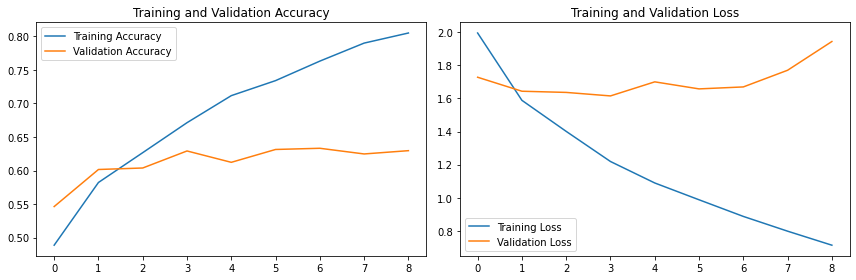

In [62]:
import matplotlib.pyplot as plt

# Plotting accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()



In [64]:
word_vector_dim = 256  # Word embedding dimension


model_LSTM14 = build_residual_lstm_model()
model_LSTM14.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_21 (Embedding)        (None, 200, 256)     7931648     input_8[0][0]                    
__________________________________________________________________________________________________
lstm_34 (LSTM)                  (None, 200, 32)      36992       embedding_21[0][0]               
__________________________________________________________________________________________________
lstm_35 (LSTM)                  (None, 32)           8320        lstm_34[0][0]                    
____________________________________________________________________________________________

In [65]:
model_LSTM14.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with 30 epochs and apply early stopping
history = model_LSTM14.fit(x_train_pad, y_train, epochs=30, validation_data=(x_test_pad, y_test), callbacks=[early_stopping])

Epoch 1/30
281/281 [==============================] - 8s 19ms/step - loss: 1.9317 - accuracy: 0.5163 - val_loss: 1.6535 - val_accuracy: 0.5646
Epoch 2/30
281/281 [==============================] - 5s 16ms/step - loss: 1.5144 - accuracy: 0.5982 - val_loss: 1.5616 - val_accuracy: 0.6006
Epoch 3/30
281/281 [==============================] - 5s 17ms/step - loss: 1.2998 - accuracy: 0.6499 - val_loss: 1.5156 - val_accuracy: 0.6198
Epoch 4/30
281/281 [==============================] - 5s 16ms/step - loss: 1.0997 - accuracy: 0.7070 - val_loss: 1.5644 - val_accuracy: 0.6242
Epoch 5/30
281/281 [==============================] - 5s 17ms/step - loss: 0.9543 - accuracy: 0.7423 - val_loss: 1.5485 - val_accuracy: 0.6536
Epoch 6/30
281/281 [==============================] - 5s 17ms/step - loss: 0.8268 - accuracy: 0.7754 - val_loss: 1.7365 - val_accuracy: 0.5721
Epoch 7/30
281/281 [==============================] - 5s 17ms/step - loss: 0.7490 - accuracy: 0.7963 - val_loss: 1.5879 - val_accuracy: 0.6536

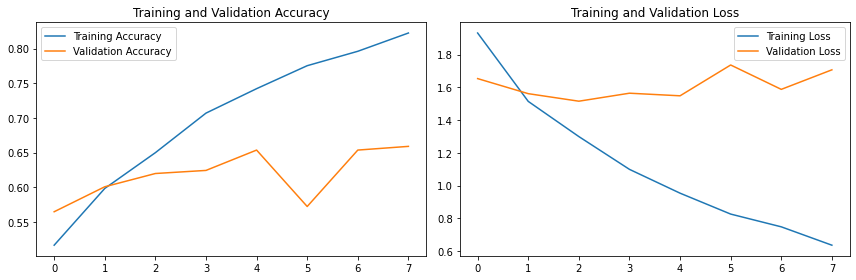

In [66]:
import matplotlib.pyplot as plt

# Plotting accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()



In [69]:
from tensorflow.keras.layers import Bidirectional

def build_bi_lstm_model():
    model = keras.Sequential()
    model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(maxlen,)))
    model.add(Bidirectional(keras.layers.LSTM(64, return_sequences=True)))
    model.add(Bidirectional(keras.layers.LSTM(32)))
    model.add(keras.layers.Dense(128, activation='relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(num_classes, activation='softmax'))
    return model

In [70]:
word_vector_dim = 256  # Word embedding dimension


model_LSTM15 = build_bi_lstm_model()
model_LSTM15.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_23 (Embedding)     (None, 200, 256)          7931648   
_________________________________________________________________
bidirectional (Bidirectional (None, 200, 128)          164352    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dense_68 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_54 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_69 (Dense)             (None, 46)                5934      
Total params: 8,151,470
Trainable params: 8,151,470
Non-trainable params: 0
___________________________________________

In [71]:
model_LSTM15.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with 30 epochs and apply early stopping
history = model_LSTM15.fit(x_train_pad, y_train, epochs=30, validation_data=(x_test_pad, y_test), callbacks=[early_stopping])

Epoch 1/30
281/281 [==============================] - 14s 34ms/step - loss: 2.1021 - accuracy: 0.4653 - val_loss: 1.7335 - val_accuracy: 0.5387
Epoch 2/30
281/281 [==============================] - 8s 30ms/step - loss: 1.7183 - accuracy: 0.5686 - val_loss: 1.6820 - val_accuracy: 0.5815
Epoch 3/30
281/281 [==============================] - 8s 29ms/step - loss: 1.5888 - accuracy: 0.5980 - val_loss: 1.6992 - val_accuracy: 0.6046
Epoch 4/30
281/281 [==============================] - 8s 30ms/step - loss: 1.4904 - accuracy: 0.6220 - val_loss: 1.6131 - val_accuracy: 0.5953
Epoch 5/30
281/281 [==============================] - 8s 30ms/step - loss: 1.2494 - accuracy: 0.6914 - val_loss: 1.5148 - val_accuracy: 0.6233
Epoch 6/30
281/281 [==============================] - 8s 30ms/step - loss: 1.0607 - accuracy: 0.7257 - val_loss: 1.4748 - val_accuracy: 0.6420
Epoch 7/30
281/281 [==============================] - 8s 30ms/step - loss: 0.9395 - accuracy: 0.7534 - val_loss: 1.5607 - val_accuracy: 0.630

In [72]:
history = model_LSTM15.fit(x_train_pad, y_train, epochs=30, validation_data=(x_test_pad, y_test), callbacks=[early_stopping])

Epoch 1/30
281/281 [==============================] - 8s 30ms/step - loss: 0.6023 - accuracy: 0.8368 - val_loss: 1.6367 - val_accuracy: 0.6585
Epoch 2/30
281/281 [==============================] - 8s 30ms/step - loss: 0.5436 - accuracy: 0.8462 - val_loss: 1.6532 - val_accuracy: 0.6701
Epoch 3/30
281/281 [==============================] - 8s 30ms/step - loss: 0.4996 - accuracy: 0.8645 - val_loss: 1.7659 - val_accuracy: 0.6857
Epoch 4/30
281/281 [==============================] - 8s 30ms/step - loss: 0.4726 - accuracy: 0.8677 - val_loss: 1.8103 - val_accuracy: 0.6763
Epoch 5/30
281/281 [==============================] - 8s 29ms/step - loss: 0.4279 - accuracy: 0.8804 - val_loss: 1.8701 - val_accuracy: 0.6674
Epoch 6/30
281/281 [==============================] - 8s 30ms/step - loss: 0.3811 - accuracy: 0.8914 - val_loss: 1.8654 - val_accuracy: 0.6719


In [81]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D, Dropout, Dense

def transformer_block(input_layer, head_size, num_heads):
    # Multi-head self-attention
    query = key = value = input_layer
    attn_output = MultiHeadAttention(num_heads=num_heads, key_dim=head_size)(query, key, value)
    attn_output = keras.layers.Dropout(0.1)(attn_output)
    out1 = LayerNormalization(epsilon=1e-6)(input_layer + attn_output)
    
    # Feed-forward layer
    ffn_output = keras.layers.Dense(128, activation="relu")(out1)
    ffn_output = keras.layers.Dense(word_vector_dim, activation="relu")(ffn_output)
    return LayerNormalization(epsilon=1e-6)(out1 + ffn_output)


def build_transformer_model():
    inputs = keras.layers.Input(shape=(maxlen,))
    x = keras.layers.Embedding(vocab_size, word_vector_dim)(inputs)
    x = transformer_block(x, head_size=64, num_heads=2)
    x = GlobalAveragePooling1D()(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.1)(x)
    outputs = Dense(num_classes, activation="softmax")(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model


In [83]:
word_vector_dim = 512  # Word embedding dimension


model_transformer16 = build_transformer_model()
model_transformer16.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_29 (Embedding)        (None, 200, 512)     15863296    input_14[0][0]                   
__________________________________________________________________________________________________
multi_head_attention_5 (MultiHe (None, 200, 512)     263040      embedding_29[0][0]               
                                                                 embedding_29[0][0]               
                                                                 embedding_29[0][0]               
____________________________________________________________________________________________

In [84]:
model_transformer16.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with 30 epochs and apply early stopping
history = model_transformer16.fit(x_train_pad, y_train, epochs=30, validation_data=(x_test_pad, y_test), callbacks=[early_stopping])

Epoch 1/30
281/281 [==============================] - 9s 28ms/step - loss: 1.4862 - accuracy: 0.6468 - val_loss: 0.9965 - val_accuracy: 0.7658
Epoch 2/30
281/281 [==============================] - 8s 27ms/step - loss: 0.7078 - accuracy: 0.8340 - val_loss: 0.9004 - val_accuracy: 0.7867
Epoch 3/30
281/281 [==============================] - 8s 27ms/step - loss: 0.4208 - accuracy: 0.8972 - val_loss: 0.9714 - val_accuracy: 0.7903
Epoch 4/30
281/281 [==============================] - 8s 27ms/step - loss: 0.2967 - accuracy: 0.9225 - val_loss: 1.0655 - val_accuracy: 0.7845
Epoch 5/30
281/281 [==============================] - 8s 27ms/step - loss: 0.2333 - accuracy: 0.9392 - val_loss: 1.3182 - val_accuracy: 0.7778
Epoch 6/30
281/281 [==============================] - 8s 28ms/step - loss: 0.1950 - accuracy: 0.9427 - val_loss: 1.3478 - val_accuracy: 0.7729
Epoch 7/30
281/281 [==============================] - 8s 28ms/step - loss: 0.1665 - accuracy: 0.9488 - val_loss: 1.6352 - val_accuracy: 0.7729

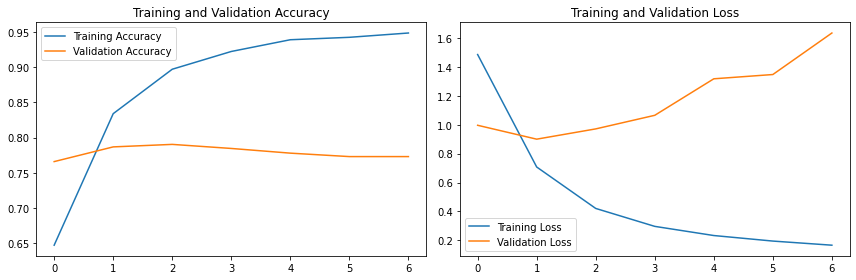

In [85]:

# Plotting accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.tight_layout()
plt.show()

In [86]:
loss, accuracy = model_transformer16.evaluate(x_test_pad, y_test, verbose=1)

print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy*100:.2f}%")

71/71 [==============================] - 1s 8ms/step - loss: 1.6352 - accuracy: 0.7729
Test Loss: 1.6352
Test Accuracy: 77.29%


Even transformer couldn't achieve 80%.

For small dataset, traditional machine learning could be better than deep learning as it needs more data.

## Summary

### Machine Learning

| *Num_words*        | 26.5k |       | 5k    |       | 3k    |       |
|---------------------|-------|-------|-------|-------|-------|-------|
|                     | **ACC(%)**   | **F1(%)**    | **ACC(%)**   | **F1(%)**    | **ACC(%)**   | **F1(%)**    |
| NB                  | 59.97 | 50.46 | 67.32 | 60.13 | 68.74 | 62.66 |
| CNB                 | 76.49 | 73.47 | 77.07 | 74.59 | 76.45 | 73.7  |
| **Logistic Regression** | **81.61** | **81.11** | **80.54** | **80.06** | 78.98 | 78.53 |
| Linear SVM          | 77.78 | 77.27 | 76.14 | 75.61 | 74.84 | 74.53 |
| Dicision tree       | 62.11 | 57.69 | 61.8  | 57.3  | 62.6  | 58    |
| Random Forest       | 65.45 | 62.26 | 70.12 | 67.7  | 68.57 | 65.92 |
| GBT                 | 77.03 | 76.42 | 76.76 | 76362 | 77.56 | 77.21 |
| **Voting**             | **81.61** | **81.27** | **81.17** | **80.86** | **80.1**  | 79.71 |

 Over 80% cases: Logistic Regression(num_words = 26.5k, 5k), Voting(num_words = 26.5k, 5k, 3k(F1 score lesser than 80%)
 
 Best case: Voting(num_words = 26.5k) - ACC: 81.61%, F1: 81.27%
 
### Deep Learning

- shallow LSTM : 67%
- deeper LSTM : 56%
- even deeper LSTM : 57%
- residual LSTM : 66%
- bi LSTM : 69%
- transformer : 79%


## Result

For small dataset, traditional machine learning could be better than deep learning as deep learning have more parameters to learn.
